In [14]:
# Importing dependencies
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.precision",2)
pd.set_option("display.max_columns",None)

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, learning_curve

import pickle

In [15]:
# loading the dataset
df = pd.read_pickle('./pickled/Train_set_scaled')

In [16]:
df.head()

,index,ID,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Together,Marital Status_Widow,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
0,1998,5370,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.34,1.61,-0.88,1.02,-0.93,0.75,-0.38,-0.19,-0.59,-0.10,-0.69,-0.49,-0.41,0.88,1.07,-0.57,0.06,1.11,0.0,0.0
1,814,6303,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.46,1.61,1.87,-0.82,-0.93,-0.57,0.79,0.33,1.18,2.61,0.71,3.27,-0.27,-1.22,0.34,0.80,1.92,-1.78,0.0,0.0
2,1513,9264,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.46,-0.78,1.29,-0.82,-0.93,-1.23,-1.66,0.36,0.40,2.43,0.66,4.15,2.92,-0.70,-0.03,1.82,0.99,-1.37,0.0,0.0
3,1381,7514,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,-1.11,0.81,0.12,1.02,0.92,0.54,0.86,-0.66,-0.41,-0.58,-0.48,-0.41,-0.31,0.88,-0.39,-0.57,-0.55,0.28,0.0,0.0
4,919,4637,0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,-1.29,1.61,1.07,-0.82,-0.93,0.23,0.83,1.98,0.95,1.34,2.00,-0.66,-0.54,-0.70,0.70,2.16,0.99,-0.96,0.0,0.0


Lets seperate Train,Test(Validation) Set

In [17]:
df['Target'] = df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3'] + \
    df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']

In [18]:
df['Target'].replace(
    df[df['Target']>0]['Target'].values.tolist(),
    1,
    inplace = True
)

In [19]:
X = df.drop(columns=['index', 'ID', 'AcceptedCmp1', 'AcceptedCmp2',
                     'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Target'])
y = df['Target']

In [20]:
X_train, X_test, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [21]:
X_train.shape , y_valid.shape

((1327, 26), (443,))

In [22]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [23]:
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)

In [24]:
cross_val_score(rfc,X,y,cv=skf,scoring='roc_auc').mean()

0.8350017718190985

In [25]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [26]:
rfc_pred = rfc.predict(X_test)
roc_auc_score(y_valid,rfc_pred)

0.7278197262859839

Note:
- Overfitting is happening here!

Lets plot the learning Curve:

In [27]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [29]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train,val_train,val_test = learning_curve(
        rfc,X,y,train_sizes=train_sizes,cv=skf,shuffle=True,scoring='roc_auc'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True);

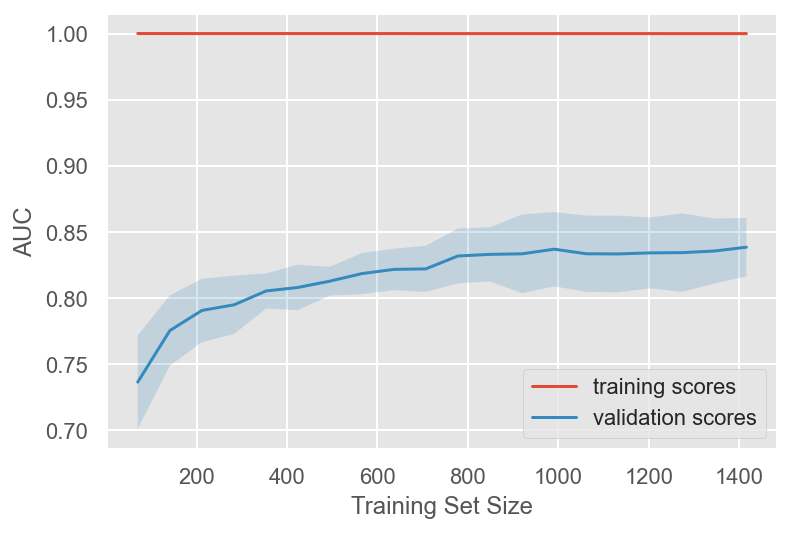

In [30]:
plot_learning_curve()

Seems like more data surely would help our model! 